In [15]:
import re
import gc
import os
import pickle
import random
from preprocess import preprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold,StratifiedKFold, train_test_split
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, roc_curve
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report,f1_score
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D, GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_colwidth',-1)

In [16]:
df_ = pd.read_csv(r'DK.csv', encoding='utf-8')

In [17]:
df_['NegetiveFeedback'].value_counts()

0    2624635
1    308112 
Name: NegetiveFeedback, dtype: int64

In [18]:
df_['len'] = df_['Comment'].astype(str).apply(lambda x: len(x.split()))
df_.head()

,Unnamed: 0,BadComment,Comment,Date,GoodComment,ItemURL,NegetiveFeedback,Person,PositiveFeedback,SubCatName,SubName,Unnamed: 0.1,Unnamed: 0.1.1,len
0,0,۰,<p>من کاملا با این محصول آشنا بودم و از خریدش مطمین بودم</p>,\r\n در تاریخ ۲ مهر ۱۳۹۹\r\n,۰,/product/dkp-1878144/ساعت-هوشمند-سامسونگ-مدل-galaxy-watch-active2-44mm,0,\r\n سمانه خلج مهرآبادي\r\n,1,ساعت هوشمند,کالای دیجیتال,NaN,NaN,12
1,1,۲,<p>به درد خاصی نمیخوره صرفا یکی دو روز باهاش سرگرمین بعد به عنوان یه ساعت معمولی ازش استفاده میکنین</p>,\r\n در تاریخ ۱ مهر ۱۳۹۹\r\n,۴,/product/dkp-1878144/ساعت-هوشمند-سامسونگ-مدل-galaxy-watch-active2-44mm,0,\r\n محجوبه زارعی\r\n,0,ساعت هوشمند,کالای دیجیتال,NaN,NaN,19
2,2,۰,<p>در یک کلام به نسبت هزینه ای که میکنید کالمل ترین ساعت بازار رو دریافت می‌کنید<br/>\r\r\nدسترسی کامل به نوتیفیکشن ها و توانایی به پاسخ دادن به پیام ها از طریق خود ساعت<br/>\r\r\nهمچنین برنامه کامل ورزشی تمام نیاز های شما رو برآورده میکنه</p>,\r\n در تاریخ ۳۱ شهریور ۱۳۹۹\r\n,۰,/product/dkp-1878144/ساعت-هوشمند-سامسونگ-مدل-galaxy-watch-active2-44mm,0,\r\n محمد رضا میرشکار سیاهکل\r\n,0,ساعت هوشمند,کالای دیجیتال,NaN,NaN,44
3,3,۰,<p>ساعت بسیار عالی و کاربردی هست،میخواستم برای دوستم هم بگیرم ولی به دلیل تفاوت قیمت زیاد از دیجی کالا نمیخرم،</p>,\r\n در تاریخ ۲۹ شهریور ۱۳۹۹\r\n,۰,/product/dkp-1878144/ساعت-هوشمند-سامسونگ-مدل-galaxy-watch-active2-44mm,0,\r\n کاربر دیجی‌کالا\r\n,0,ساعت هوشمند,کالای دیجیتال,NaN,NaN,20
4,4,۰,<p>دقیقا مطابق آنچه انتظار می رفت بود .<br/>\r\r\nخوب و کاربردی و مطابق استایل روز .</p>,\r\n در تاریخ ۲۹ شهریور ۱۳۹۹\r\n,۱,/product/dkp-1878144/ساعت-هوشمند-سامسونگ-مدل-galaxy-watch-active2-44mm,0,\r\n محمد میرفخرایی\r\n,1,ساعت هوشمند,کالای دیجیتال,NaN,NaN,16


In [19]:
print(len(df_))
df = df_[(df_['PositiveFeedback']==1)|(df_['NegetiveFeedback']==1)]
print(len(df))

2932747
2057167


In [20]:
df = df.sample(frac=1.0)

In [21]:
df['Label'] = 0
df.loc[df['NegetiveFeedback']==1,'Label'] = 1
df.head()

,Unnamed: 0,BadComment,Comment,Date,GoodComment,ItemURL,NegetiveFeedback,Person,PositiveFeedback,SubCatName,SubName,Unnamed: 0.1,Unnamed: 0.1.1,len,Label
695387,679665,۰,<p>تو تخفیف بخرید راضی کننده است</p>,\r\r\n در تاریخ ۱۱ شهریور ۱۳۹۸\r\r\n,۲,/product/dkp-619604/کارت-شبکه-usb-بی-سیم-مدل-300mbps-آنتن-کوتاه,0,\r\r\n حسین ر\r\r\n,1,تجهیزات شبکه و ارتباطات,کالای دیجیتال,7710.0,NaN,6,0
1797123,800206,۸,<p>ساعت زبان فارسی دارد<br/>\r\r\nتاج بسیار قوی<br/>\r\r\nنسبت به قیمت عالیه</p>,\r\n در تاریخ ۱ آذر ۱۳۹۸\r\n,۹,/product/dkp-877254/ساعت-هوشمند-مدل-a1-به-همراه-هندزفری-بی-سیم-i7s-tws,0,\r\n مسعود غفوری\r\n,1,ساعت هوشمند,کالای دیجیتال,2448.0,2448.0,11,0
2250073,1253156,۰,<p>ساعت خیلی خوبیه همه چیزش عالی کار میکنه اگر باتریش کمی قوی بود عالی تر میشد</p>,\r\n در تاریخ ۲۸ دی ۱۳۹۸\r\n,۰,/product/dkp-427426/ساعت-هوشمند-میدسان-مدل-a1,0,\r\n amin rayati\r\n,1,ساعت هوشمند,کالای دیجیتال,6907.0,6907.0,16,0
1249076,252159,۰,<p>خوبه ساعته بدی نیست بیشتر به درد ورزشکارا میخوره ولی انگار مشکی نیس!!بندش و دورش سورمه ایه!!درصورتی ک مشکی سفارش دادم ولی د کل راضیم از همه چیش کیفیتش عالی همه چیش عالی</p>,\r\n در تاریخ ۲۷ فروردین ۱۳۹۹\r\n,۱,/product/dkp-2005406/ساعت-هوشمند-سامسونگ-مدل-galaxy-watch-active2-40mm,0,\r\n رعنا سامانی\r\n,1,ساعت هوشمند,کالای دیجیتال,2159.0,2159.0,33,0
2712725,1715808,۰,<p>کیبرد ش زبان فارسی نداره ولی در کل زبان فارسی دارد</p>,\r\n در تاریخ ۲۹ اردیبهشت ۱۳۹۹\r\n,۲,/product/dkp-390726/ساعت-هوشمند-وی-سریز-مدل-a1,0,\r\n نوراله بردبار\r\n,1,ساعت هوشمند,کالای دیجیتال,6434.0,6434.0,11,0


In [22]:
df['Label'].value_counts()

0    1749055
1    308112 
Name: Label, dtype: int64

In [24]:
prep = preprocess()
df['Comment'] = df['Comment'].apply(lambda x: prep.clean(x))

In [25]:
X = df['Comment'].values
Y = df['Label'].values

In [52]:
embed_num_dims = 100
max_seq_len = 400
EMB_SIZE = 100
MAX_LEN = 1000
seed = 2020
random.seed(seed)

skf = StratifiedKFold(n_splits=5)
batch_size = 2048
epoches = 7

In [27]:
tokenizer = Tokenizer(num_words=2000000,filters='!"#$%&()*+,-./;<=>?@][\\]^{|}~\t\n')
tokenizer.fit_on_texts(X)
index_of_words = tokenizer.word_index

In [28]:
def get_coefs(word,*arr):
    return word,np.asarray(arr,dtype='float32')
def build_embed_matrix(embed_path,word_index):
    EMB_SIZE =100
    embed_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embed_path, encoding='utf-8'))
    embed_matrix = np.zeros((len(word_index)+1,EMB_SIZE))
    
    for word , i in word_index.items():
        embed_vector = embed_index.get(word)
        if embed_vector is not None:
            embed_matrix[i]=embed_vector
    del embed_index
    gc.collect()
    return embed_matrix

In [29]:
embed_path = 'NewDigi.vec'
embed_matrix_fasts = build_embed_matrix(embed_path,index_of_words)

In [53]:
def Evaluation(Ytest, pred_class, pred_proba, fold):
    
    auc = roc_auc_score(Ytest,pred_proba)
    fpr, tpr, threshold = roc_curve(Ytest, pred_proba)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig('auc'+str(fold)+'.png')
    plt.show()
    print('AUC:', auc)
    print('f1_score:', f1_score(Ytest,pred_class))
    print('Confusion Matrix:\n', confusion_matrix(Ytest,pred_class))

In [54]:
def create_model():
    model = Sequential()
    model.add(Embedding(len(index_of_words)+1, 100, input_length=max_seq_len, weights=[embed_matrix_fasts]))
    model.add(Dropout(0.5))
    model.add(Conv1D(128,kernel_size=3,padding='same',activation='relu',strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

#Fold: 1
Oversampling ...
Pad Sequencing ...
Modeling ...
Epoch 1/7
578/578 [==============================] - 157s 272ms/step - loss: 0.2459 - accuracy: 0.9049 - val_loss: 0.1103 - val_accuracy: 0.9620
Epoch 2/7
578/578 [==============================] - 157s 272ms/step - loss: 0.1551 - accuracy: 0.9456 - val_loss: 0.0841 - val_accuracy: 0.9725
Epoch 3/7
578/578 [==============================] - 157s 272ms/step - loss: 0.1319 - accuracy: 0.9565 - val_loss: 0.0777 - val_accuracy: 0.9740
Epoch 4/7
578/578 [==============================] - 157s 272ms/step - loss: 0.1185 - accuracy: 0.9613 - val_loss: 0.0752 - val_accuracy: 0.9744
Epoch 5/7
578/578 [==============================] - 157s 272ms/step - loss: 0.1101 - accuracy: 0.9644 - val_loss: 0.0698 - val_accuracy: 0.9758
Epoch 6/7
578/578 [==============================] - 157s 272ms/step - loss: 0.1034 - accuracy: 0.9664 - val_loss: 0.0671 - val_accuracy: 0.9769
Epoch 7/7
578/578 [==============================] - 157s 272ms/step - l

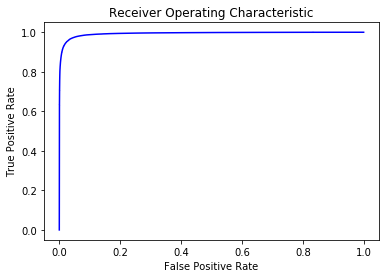

AUC: 0.9936204078485766
f1_score: 0.9240126484254001
Confusion Matrix:
 [[861849  12679]
 [ 10871 143185]]
#Fold: 2
Oversampling ...
Pad Sequencing ...
Modeling ...
Epoch 1/7
578/578 [==============================] - 158s 273ms/step - loss: 0.2496 - accuracy: 0.9023 - val_loss: 0.1126 - val_accuracy: 0.9614
Epoch 2/7
578/578 [==============================] - 157s 272ms/step - loss: 0.1584 - accuracy: 0.9442 - val_loss: 0.0876 - val_accuracy: 0.9716
Epoch 3/7
578/578 [==============================] - 157s 272ms/step - loss: 0.1341 - accuracy: 0.9535 - val_loss: 0.0748 - val_accuracy: 0.9749
Epoch 4/7
578/578 [==============================] - 157s 272ms/step - loss: 0.1203 - accuracy: 0.9584 - val_loss: 0.0707 - val_accuracy: 0.9758
Epoch 5/7
578/578 [==============================] - 157s 272ms/step - loss: 0.1112 - accuracy: 0.9640 - val_loss: 0.0720 - val_accuracy: 0.9741
Epoch 6/7
578/578 [==============================] - 158s 273ms/step - loss: 0.1047 - accuracy: 0.9663 - val_l

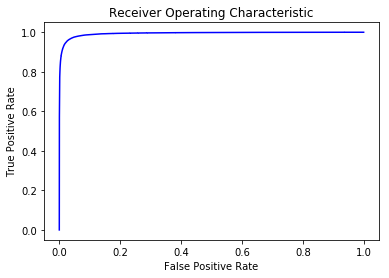

AUC: 0.9938488879647955
f1_score: 0.9217086611665022
Confusion Matrix:
 [[859329  15198]
 [  9380 144676]]


In [34]:
for fold, (train_index, test_index) in enumerate(skf.split(X,Y)):
    
    print('#Fold:', fold+1)
    
    Xtrain, Xtest = X[train_index], X[test_index]
    Ytrain, Ytest = Y[train_index], Y[test_index]
    
    print('Oversampling ...')
    Xtrain = np.append(Xtrain, Xtrain[Ytrain==1])
    Ytrain = np.append(Ytrain, Ytrain[Ytrain==1])
    
    print('Pad Sequencing ...')
    sequence_train = tokenizer.texts_to_sequences(Xtrain)
    sequence_test = tokenizer.texts_to_sequences(Xtest)
    padata_train = pad_sequences(sequence_train,maxlen=max_seq_len, padding='post')
    padata_test = pad_sequences(sequence_test,maxlen=max_seq_len, padding='post')
    
    print('Modeling ...')
    model = create_model()
    history= model.fit(padata_train, Ytrain, validation_data=(padata_test,Ytest),epochs=epoches, batch_size=batch_size,
                       verbose=1, shuffle=True)
    
    print('Evaluating ...')
    pred_class = model.predict_classes(padata_test)
    pred_proba = model.predict(padata_test)
    Evaluation(Ytest, pred_class, pred_proba, fold)

# Pseudo Labeling ...

In [35]:
df_psudo = df_[(df_['PositiveFeedback']==0)&(df_['NegetiveFeedback']==0)] # unlabeled data
len(df_psudo)

875580

In [36]:
df_psudo['Comment'] = df_psudo['Comment'].apply(lambda x: prep.clean(x))
X_psudo = df_psudo['Comment'].values

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
sequence_psudo = tokenizer.texts_to_sequences(X_psudo)
padata_psudo = pad_sequences(sequence_psudo,maxlen=max_seq_len, padding='post')

In [38]:
pred_proba = model.predict(padata_psudo)

In [39]:
pred_proba

array([[9.9958760e-01],
       [9.0225785e-07],
       [1.3243133e-03],
       ...,
       [5.0279084e-03],
       [9.5633030e-01],
       [8.8879623e-02]], dtype=float32)

In [42]:
dd = pd.DataFrame({'text':X_psudo, 'proba':pred_proba[:,0]})
dd = dd[(dd['proba']<0.0000001)|(dd['proba']>0.9)]
dd['label'] = 0
dd.loc[dd['proba']>0.5,'label'] = 1

In [43]:
dd.label.value_counts()

1    104800
0    30597 
Name: label, dtype: int64

In [46]:
ddd = pd.DataFrame({'text':X, 'label':Y})

,text,label
2057128,من بخاطر اوضاع کرونا و سنسور اکسیژن این ساعت رو خریداری کردم مگرنه چیز خاصی نداره . ظاهرش هم قشنگه . ولی خیلی معمولیه,1
2057129,اگر یه سیم کارت دارید که می خوایید استفاده کنید چیز خوبیه ولی اگر می خوایید از حسگراش استفاه کنید نخرید چون اصلا حسگر نداره من خیلی جست و جو کردم اینو خریدم اخر هم چیزی که می خواستم نشد گفتم توضیحات رو بدم بقیه گول نخورن,1
2057134,واقعن عالیه ولی با قیمت کمتر میشه تسکو گرفت اینو برا خودم نگرفتم منتظرم شگفت انگیز بخورن تسکو بگیرم متاسفانه این مدل هولدر نداره هم هزینش کمتر میشینه هم کمک به ی شرکت ایرانی میشه مرسی از دیجی کالا,1
2057137,محصول با سیم های شارژر سامسونگ که من تست کردم استاندارد نیست و سایزش بزرگ است,1
2057154,اصلا اون چیزی ک انتظار داشتم نبود کیفیت صداش از هم زده های خودش پایین تره,1


In [51]:
ddd = ddd.append(dd)
ddd.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


,label,proba,text
0,0,NaN,تو تخفیف بخرید راضی کننده است
1,0,NaN,ساعت زبان فارسی دارد تاج بسیار قوی نسبت به قیمت عالیه
2,0,NaN,ساعت خیلی خوبیه همه چیزش عالی کار میکنه اگر باتریش کمی قوی بود عالی تر میشد
3,0,NaN,خوبه ساعته بدی نیست بیشتر به درد ورزشکارا میخوره ولی انگار مشکی نیس بندش و دورش سورمه ایه درصورتی ک مشکی سفارش دادم ولی د کل راضیم از همه چیش کیفیتش عالی همه چیش عالی
4,0,NaN,کیبرد ش زبان فارسی نداره ولی در کل زبان فارسی دارد


New dataset is ready for embedding and modeling

In [56]:
ddd = ddd.sample(frac=1.0)
X_p = ddd['text'].values
Y_p = ddd['label'].values

In [61]:
tokenizer = Tokenizer(num_words=2000000,filters='!"#$%&()*+,-./;<=>?@][\\]^{|}~\t\n')
tokenizer.fit_on_texts(X_p)
index_of_words = tokenizer.word_index

embed_matrix_fasts = build_embed_matrix(embed_path,index_of_words)

#Fold: 1
Oversampling ...
Pad Sequencing ...
Modeling ...
Epoch 1/7
1112/1112 [==============================] - 263s 237ms/step - loss: 0.1934 - accuracy: 0.9306 - val_loss: 0.1046 - val_accuracy: 0.9636
Epoch 2/7
1112/1112 [==============================] - 262s 236ms/step - loss: 0.1130 - accuracy: 0.9654 - val_loss: 0.0868 - val_accuracy: 0.9703
Epoch 3/7
1112/1112 [==============================] - 262s 236ms/step - loss: 0.0963 - accuracy: 0.9707 - val_loss: 0.0819 - val_accuracy: 0.9722
Epoch 4/7
1112/1112 [==============================] - 265s 238ms/step - loss: 0.0876 - accuracy: 0.9732 - val_loss: 0.0793 - val_accuracy: 0.9729
Epoch 5/7
1112/1112 [==============================] - 265s 238ms/step - loss: 0.0815 - accuracy: 0.9748 - val_loss: 0.0761 - val_accuracy: 0.9739
Epoch 6/7
1112/1112 [==============================] - 265s 238ms/step - loss: 0.0771 - accuracy: 0.9761 - val_loss: 0.0756 - val_accuracy: 0.9744
Epoch 7/7
1112/1112 [==============================] - 265s 

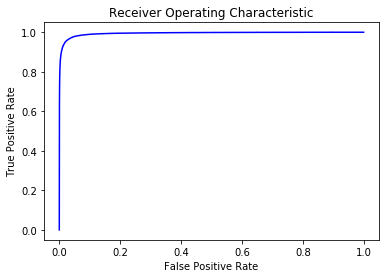

AUC: 0.9943626143175812
f1_score: 0.9430514341026531
Confusion Matrix:
 [[357492   4558]
 [  7091  96452]]
#Fold: 2
Oversampling ...
Pad Sequencing ...
Modeling ...
Epoch 1/7
1112/1112 [==============================] - 265s 238ms/step - loss: 0.1882 - accuracy: 0.9331 - val_loss: 0.1052 - val_accuracy: 0.9635
Epoch 2/7
1112/1112 [==============================] - 265s 238ms/step - loss: 0.1114 - accuracy: 0.9651 - val_loss: 0.0885 - val_accuracy: 0.9705
Epoch 3/7
1112/1112 [==============================] - 265s 238ms/step - loss: 0.0949 - accuracy: 0.9705 - val_loss: 0.0814 - val_accuracy: 0.9722
Epoch 4/7
1112/1112 [==============================] - 265s 238ms/step - loss: 0.0864 - accuracy: 0.9733 - val_loss: 0.0796 - val_accuracy: 0.9730
Epoch 5/7
1112/1112 [==============================] - 265s 238ms/step - loss: 0.0805 - accuracy: 0.9750 - val_loss: 0.0764 - val_accuracy: 0.9738
Epoch 6/7
1112/1112 [==============================] - 265s 238ms/step - loss: 0.0765 - accuracy: 0.

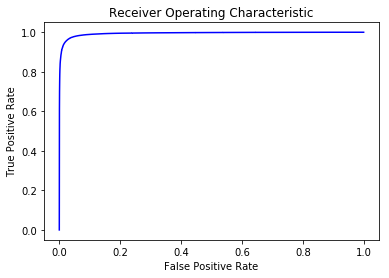

AUC: 0.9942865005179037
f1_score: 0.9434457112100603
Confusion Matrix:
 [[357628   4422]
 [  7136  96406]]
#Fold: 3
Oversampling ...
Pad Sequencing ...
Modeling ...
Epoch 1/7
1112/1112 [==============================] - 262s 235ms/step - loss: 0.1918 - accuracy: 0.9310 - val_loss: 0.1010 - val_accuracy: 0.9651
Epoch 2/7
1112/1112 [==============================] - 264s 238ms/step - loss: 0.1110 - accuracy: 0.9658 - val_loss: 0.0856 - val_accuracy: 0.9708
Epoch 3/7
1112/1112 [==============================] - 264s 237ms/step - loss: 0.0950 - accuracy: 0.9707 - val_loss: 0.0792 - val_accuracy: 0.9728
Epoch 4/7
1112/1112 [==============================] - 264s 237ms/step - loss: 0.0868 - accuracy: 0.9732 - val_loss: 0.0768 - val_accuracy: 0.9738
Epoch 5/7
1112/1112 [==============================] - 264s 237ms/step - loss: 0.0810 - accuracy: 0.9749 - val_loss: 0.0765 - val_accuracy: 0.9744
Epoch 6/7
1112/1112 [==============================] - 264s 237ms/step - loss: 0.0768 - accuracy: 0.

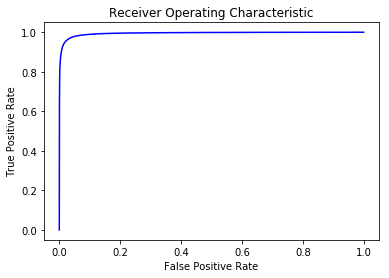

AUC: 0.9945748542567568
f1_score: 0.9443381117925083
Confusion Matrix:
 [[357488   4562]
 [  6838  96704]]
#Fold: 4
Oversampling ...
Pad Sequencing ...
Modeling ...
Epoch 1/7
1112/1112 [==============================] - 2056s 2s/step - loss: 0.2084 - accuracy: 0.9237 - val_loss: 0.0618 - val_accuracy: 0.9824
Epoch 2/7
1112/1112 [==============================] - 266s 239ms/step - loss: 0.1298 - accuracy: 0.9583 - val_loss: 0.0488 - val_accuracy: 0.9852
Epoch 3/7
1112/1112 [==============================] - 266s 239ms/step - loss: 0.1119 - accuracy: 0.9646 - val_loss: 0.0410 - val_accuracy: 0.9878
Epoch 4/7
1112/1112 [==============================] - 266s 240ms/step - loss: 0.1030 - accuracy: 0.9678 - val_loss: 0.0403 - val_accuracy: 0.9878
Epoch 5/7
1112/1112 [==============================] - 266s 239ms/step - loss: 0.0958 - accuracy: 0.9700 - val_loss: 0.0397 - val_accuracy: 0.9876
Epoch 6/7
1112/1112 [==============================] - 266s 239ms/step - loss: 0.0913 - accuracy: 0.97

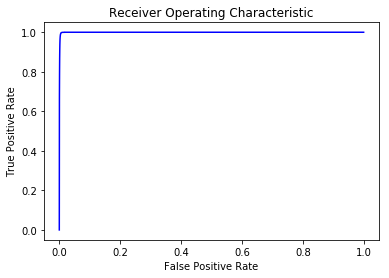

AUC: 0.9994723841351509
f1_score: 0.9767283877815779
Confusion Matrix:
 [[357138   4912]
 [    21 103521]]
#Fold: 5
Oversampling ...
Pad Sequencing ...
Modeling ...
Epoch 1/7
1112/1112 [==============================] - 267s 240ms/step - loss: 0.2137 - accuracy: 0.9216 - val_loss: 0.0532 - val_accuracy: 0.9858
Epoch 2/7
1112/1112 [==============================] - 266s 239ms/step - loss: 0.1308 - accuracy: 0.9584 - val_loss: 0.0394 - val_accuracy: 0.9893
Epoch 3/7
1112/1112 [==============================] - 267s 240ms/step - loss: 0.1133 - accuracy: 0.9644 - val_loss: 0.0341 - val_accuracy: 0.9907
Epoch 4/7
1112/1112 [==============================] - 267s 240ms/step - loss: 0.1037 - accuracy: 0.9677 - val_loss: 0.0308 - val_accuracy: 0.9917
Epoch 5/7
1112/1112 [==============================] - 267s 240ms/step - loss: 0.0971 - accuracy: 0.9697 - val_loss: 0.0331 - val_accuracy: 0.9894
Epoch 6/7
1112/1112 [==============================] - 267s 240ms/step - loss: 0.0923 - accuracy: 0.

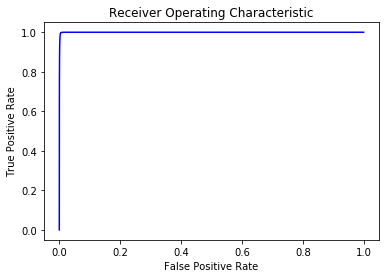

AUC: 0.9996136640729629
f1_score: 0.9758658554401971
Confusion Matrix:
 [[356937   5112]
 [     9 103534]]


In [62]:
for fold, (train_index, test_index) in enumerate(skf.split(X_p,Y_p)):
    
    print('#Fold:', fold+1)
    
    Xtrain, Xtest = X_p[train_index], X_p[test_index]
    Ytrain, Ytest = Y_p[train_index], Y_p[test_index]
    
    print('Oversampling ...')
    Xtrain = np.append(Xtrain, Xtrain[Ytrain==1])
    Ytrain = np.append(Ytrain, Ytrain[Ytrain==1])
    
    print('Pad Sequencing ...')
    sequence_train = tokenizer.texts_to_sequences(Xtrain)
    sequence_test = tokenizer.texts_to_sequences(Xtest)
    padata_train = pad_sequences(sequence_train,maxlen=max_seq_len, padding='post')
    padata_test = pad_sequences(sequence_test,maxlen=max_seq_len, padding='post')
    
    print('Modeling ...')
    model = create_model()
    history= model.fit(padata_train, Ytrain, validation_data=(padata_test,Ytest),epochs=epoches, batch_size=batch_size,
                       verbose=1, shuffle=True)
    
    print('Evaluating ...')
    pred_class = model.predict_classes(padata_test)
    pred_proba = model.predict(padata_test)
    Evaluation(Ytest, pred_class, pred_proba, fold)